# ATE Estimation with Logistic Regression

## Prepare Notebook

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from scipy.special import expit

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "logistic"))
rng: np.random.Generator = np.random.default_rng(seed=seed)


## Read Data

In [3]:
raw_df = pd.read_excel(
    "https://doi.org/10.1371/journal.pmed.1002479.s001", sheet_name="data"
)

raw_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2063 entries, 0 to 2062
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   anon_id      2063 non-null   int64  
 1   group        2063 non-null   object 
 2   imd_decile   2063 non-null   int64  
 3   partners     2063 non-null   object 
 4   gender       2063 non-null   object 
 5   msm          2063 non-null   object 
 6   ethnicgrp    2063 non-null   object 
 7   age          2063 non-null   int64  
 8   anytest_sr   1880 non-null   float64
 9   anydiag_sr   1880 non-null   float64
 10  anytreat_sr  1875 non-null   float64
 11  anytest      1739 non-null   float64
 12  anydiag      1739 non-null   float64
 13  anytreat     1730 non-null   float64
 14  time_test    1739 non-null   float64
 15  time_treat   1730 non-null   float64
 16  sh24_launch  2063 non-null   object 
dtypes: float64(8), int64(3), object(6)
memory usage: 274.1+ KB


In [4]:
raw_df.groupby(["group", "anytest"], as_index=False, dropna=False).agg(
    {"anon_id": "count"}
)


,group,anytest,anon_id
0,Control,0.0,645
1,Control,1.0,173
2,Control,NaN,214
3,SH:24,0.0,482
4,SH:24,1.0,439
5,SH:24,NaN,110


## Data Preprocessing

In [5]:
df = (
    raw_df.copy()
    .filter(items=["anytest", "group"])
    .dropna(axis=0)
    .assign(tx=lambda x: x["group"].map({"Control": 0, "SH:24": 1}))
    .drop(columns="group")
)

## Difference in Means

In [6]:
diff_means = (
    df.query("tx == 1")["anytest"].mean() - df.query("tx == 0")["anytest"].mean()
)

print(f"Sample ATE: {diff_means:.3f}")

Sample ATE: 0.265


## Logistic Regression Model

In [7]:
logistic_model_priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=1.25),
    "tx": bmb.Prior("Normal", mu=0, sigma=1),
}

logistic_model = bmb.Model(
    formula="anytest ~ tx",
    data=df,
    family="bernoulli",
    link="logit",
    priors=logistic_model_priors,
)

logistic_model


       Formula: anytest ~ tx
        Family: bernoulli
          Link: p = logit
  Observations: 1739
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.25)
            tx ~ Normal(mu: 0.0, sigma: 1.0)

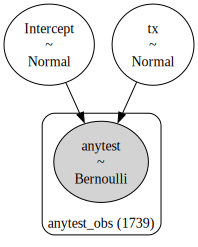

In [8]:
logistic_model.build()
logistic_model.graph()

Sampling: [Intercept, tx]
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Text(0.5, 0.98, 'Logistic Regression Priors (logit scale)')

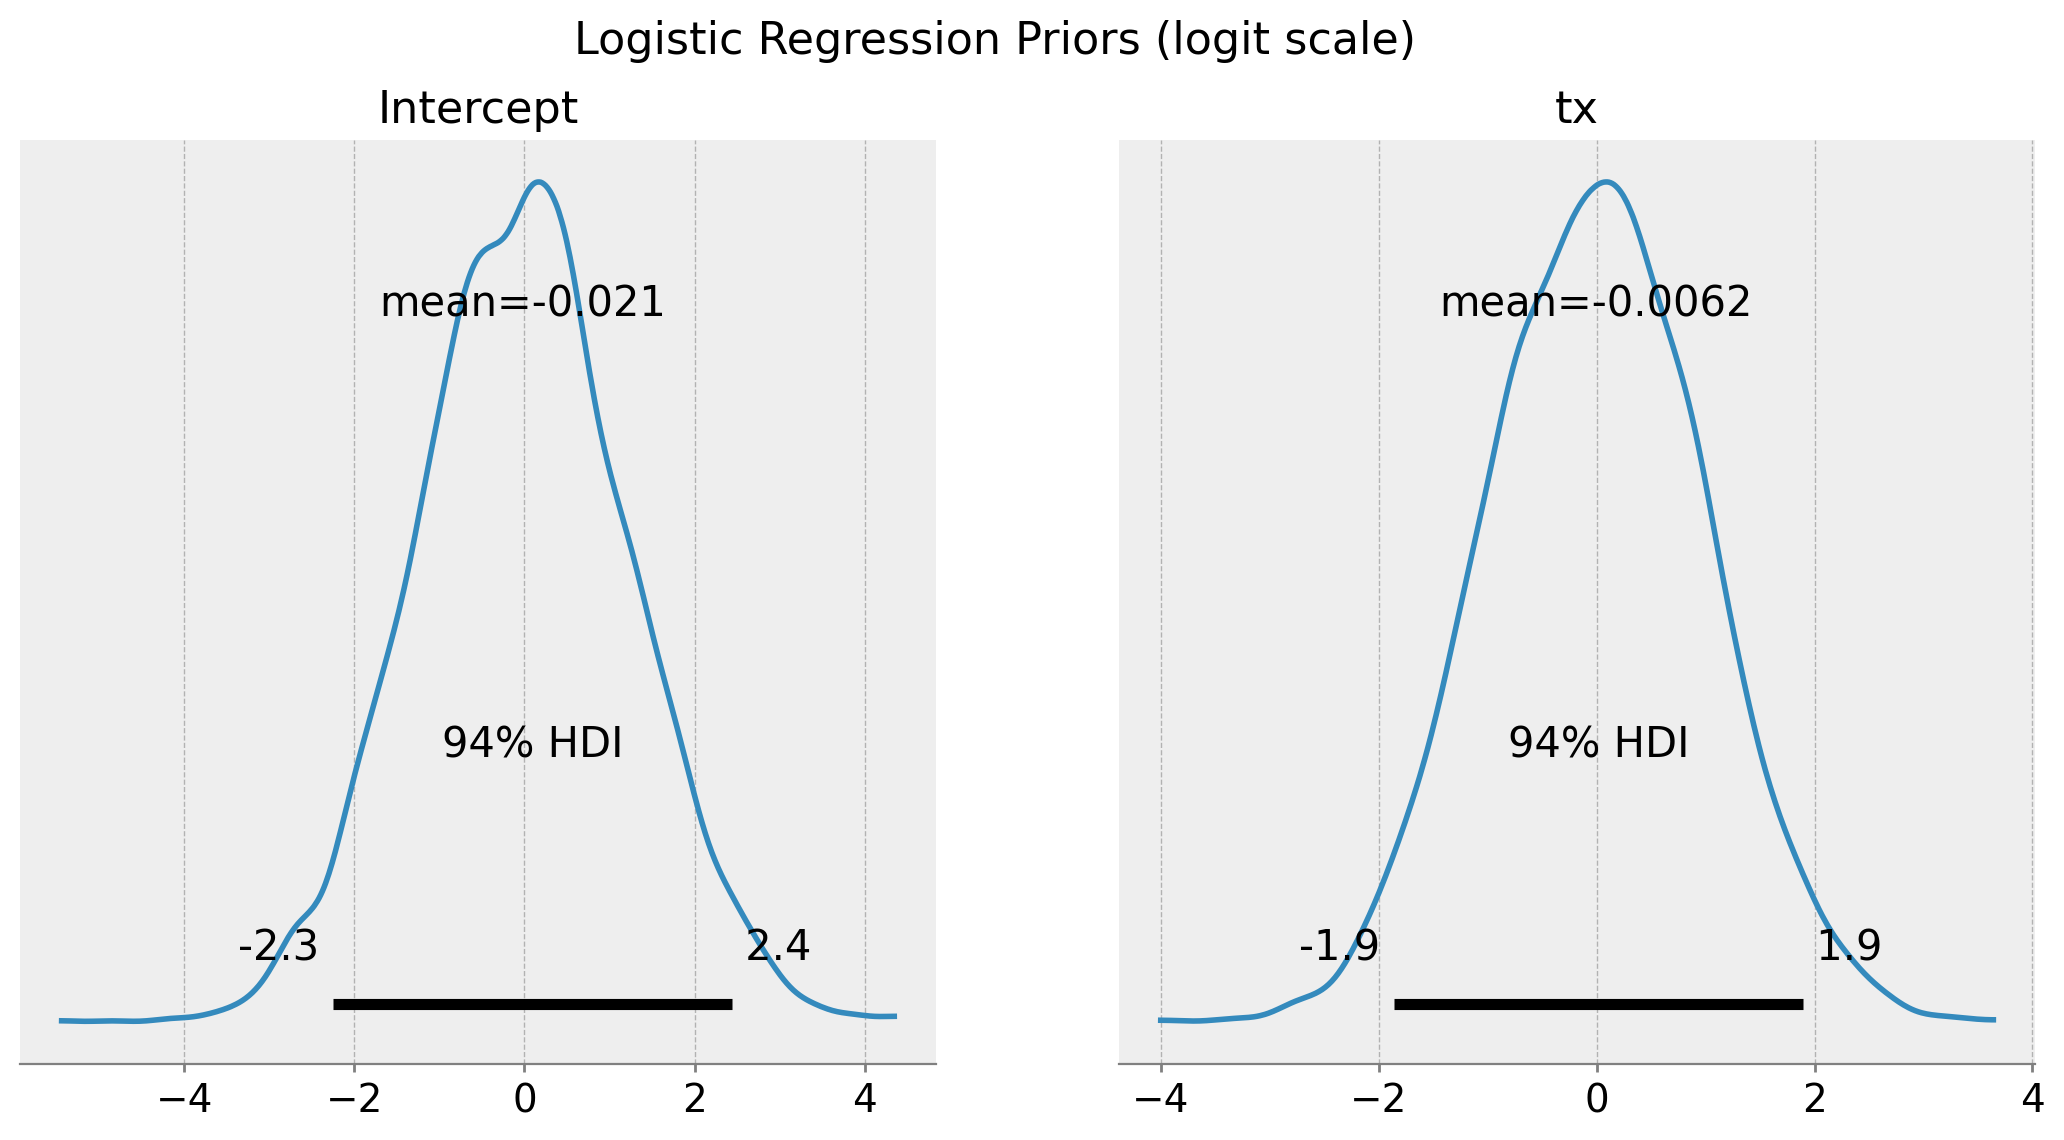

In [9]:
axes = logistic_model.plot_priors(draws=10_000, figsize=(13, 6), random_seed=rng)
plt.gcf().suptitle("Logistic Regression Priors (logit scale)", fontsize=16)


[Text(0.5, 1.0, 'Logistic Regression Prior (original scale)')]

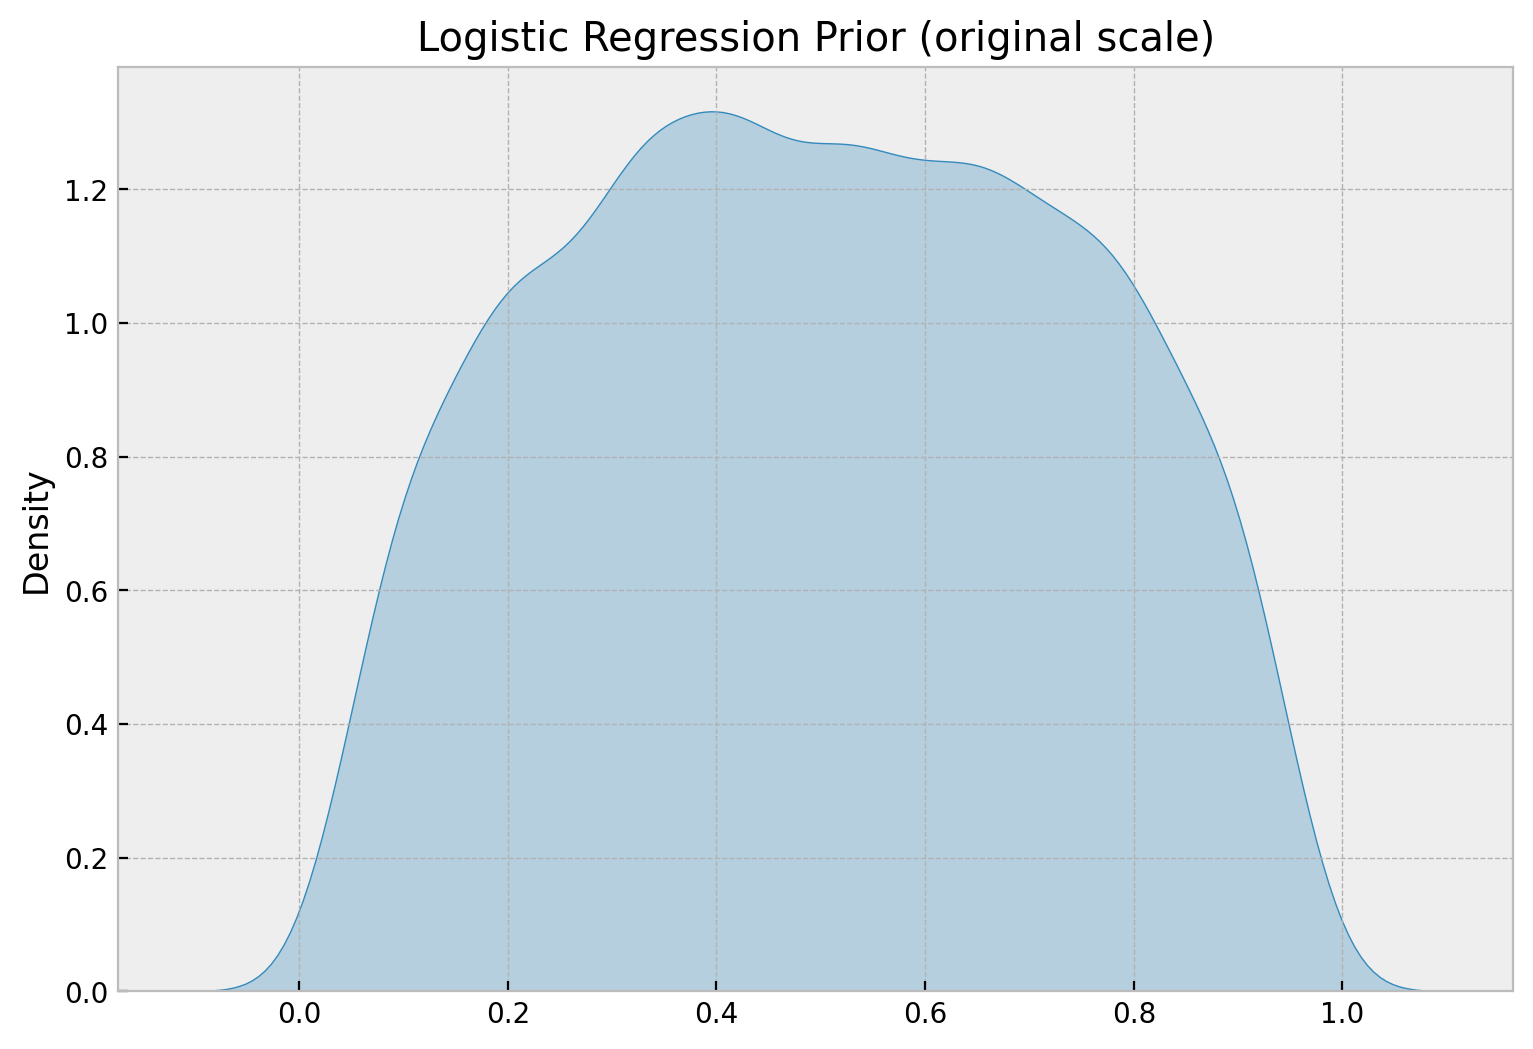

In [10]:
normal_prior = pm.Normal.dist(mu=0, sigma=1.25)
samples_normal_prior = pm.draw(vars=normal_prior, draws=10_000)

fig, ax = plt.subplots(figsize=(9, 6))
sns.kdeplot(data=expit(samples_normal_prior), fill=True, alpha=0.3)
ax.set(title="Logistic Regression Prior (original scale)")

In [40]:
logistic_idata = logistic_model.fit(
    draws=4_000, chains=5, nuts_sampler="numpyro", random_seed=rng
)


Modeling the probability that anytest==1
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.574962
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:06.149825
Transforming variables...
Transformation time =  0:00:00.011445


In [12]:
az.summary(data=logistic_idata)

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.307,0.085,-1.470,-1.152,0.001,0.001,9833.0,9645.0,1.0
tx,1.210,0.107,1.015,1.415,0.001,0.001,12280.0,9933.0,1.0


<module 'arviz' from '/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/arviz/__init__.py'>

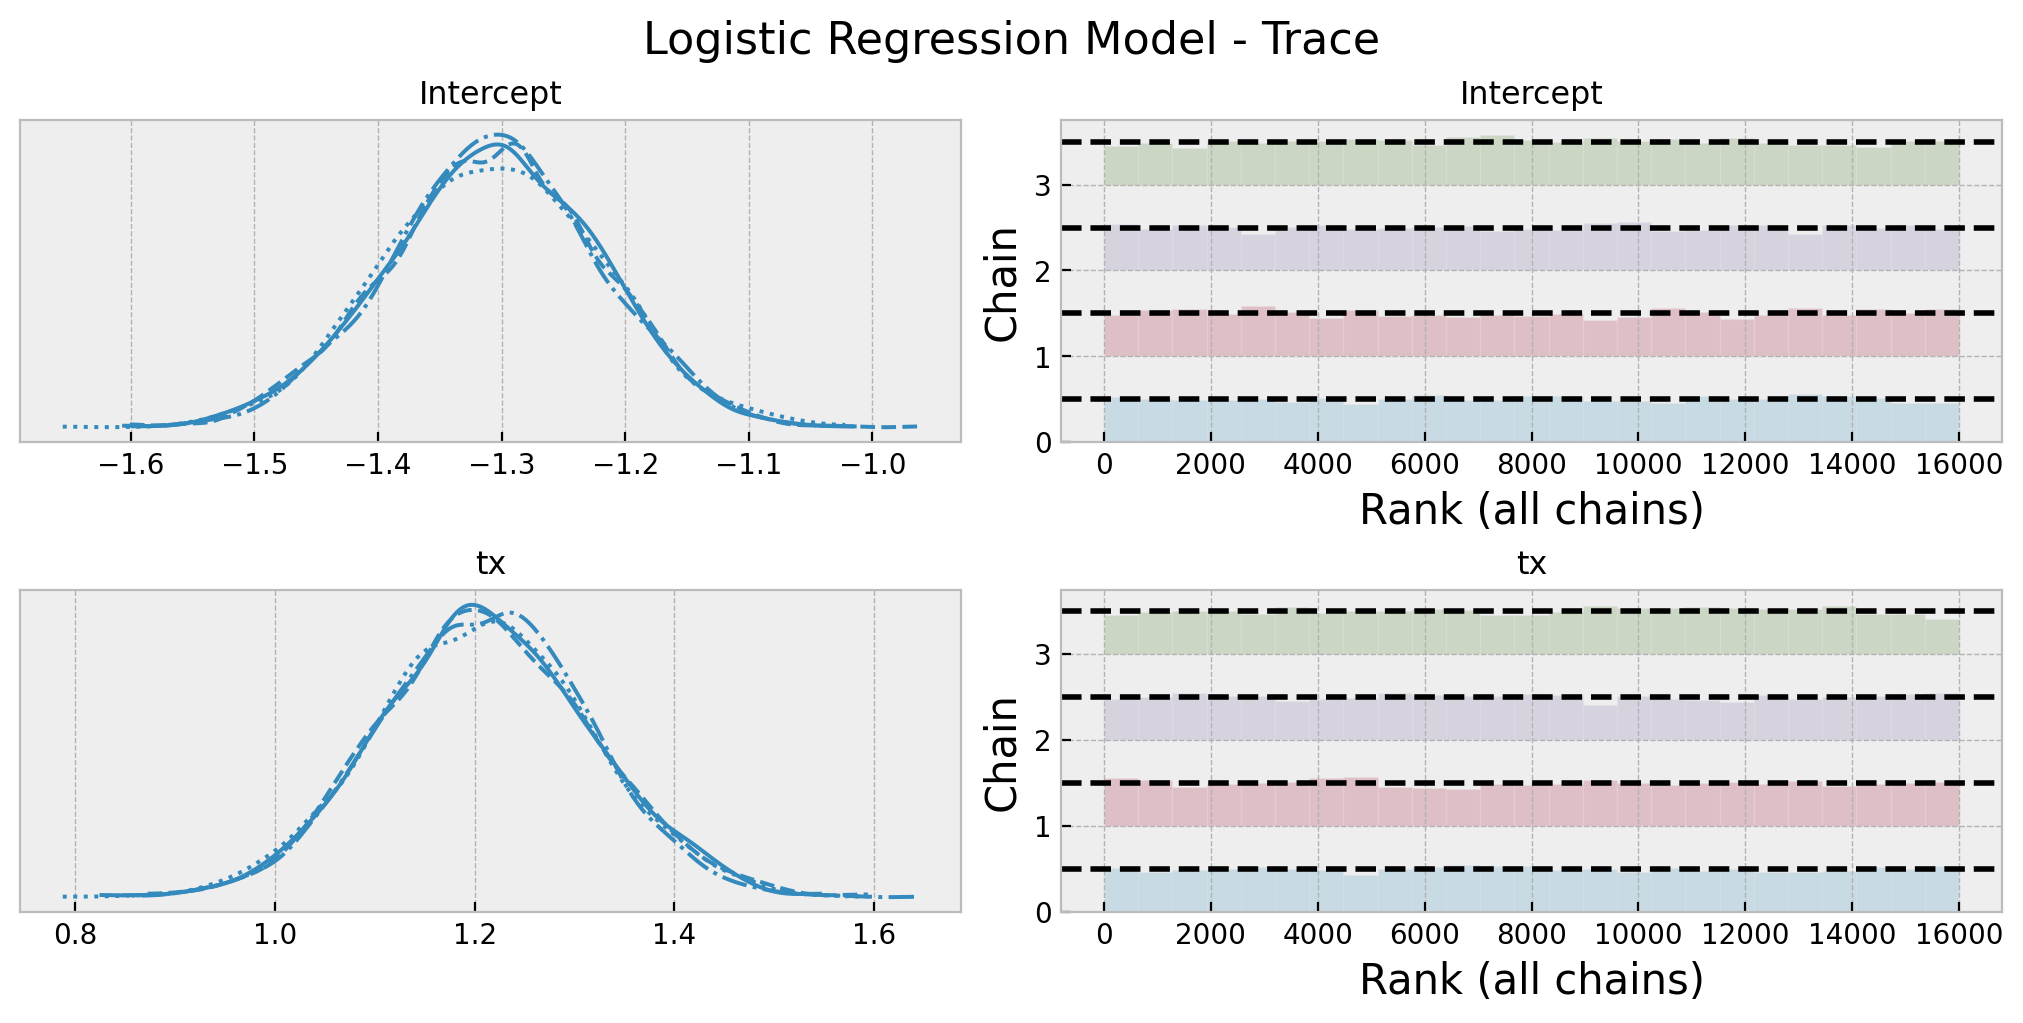

In [13]:
axes = az.plot_trace(
    data=logistic_idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 5), "layout": "constrained"},
)
plt.gcf().suptitle("Logistic Regression Model - Trace", fontsize=16);az

[Text(0.5, 1.0, 'Logistic Regression Model - ATE'), Text(0.5, 0, 'ATE')]

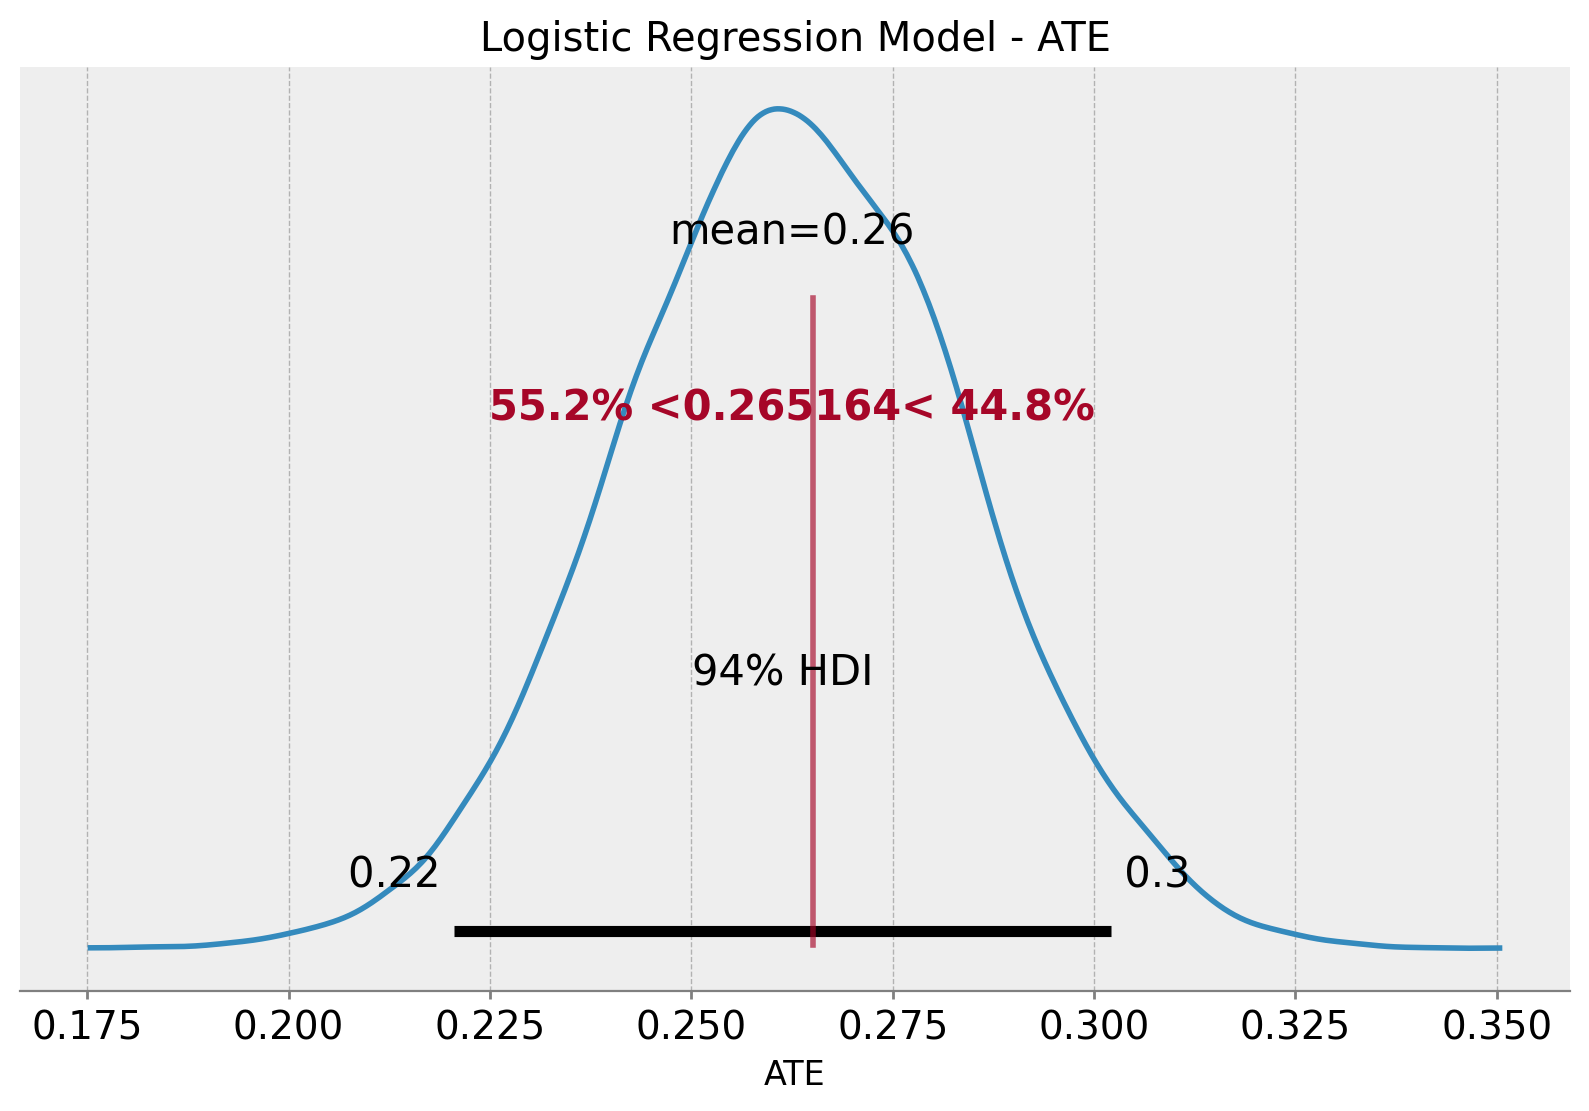

In [14]:
ate_samples = expit(
    logistic_idata["posterior"]["Intercept"] + logistic_idata["posterior"]["tx"]
) - expit(logistic_idata["posterior"]["Intercept"])

fig, ax = plt.subplots()
az.plot_posterior(data=ate_samples, ref_val=diff_means, ax=ax)
ax.set(title="Logistic Regression Model - ATE", xlabel="ATE")

## Linear Regression Model (OLS)

In [22]:
gaussian_model_priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=1),
    "tx": bmb.Prior("Normal", mu=0, sigma=1),
    "sigma": bmb.Prior("Exponential", lam=1),
}
gaussian_model = bmb.Model(
    formula="anytest ~ tx",
    data=df,
    family="gaussian",
    link="identity",
    priors=gaussian_model_priors,
)

gaussian_model


       Formula: anytest ~ tx
        Family: gaussian
          Link: mu = identity
  Observations: 1739
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            tx ~ Normal(mu: 0.0, sigma: 1.0)
        
        Auxiliary parameters
            anytest_sigma ~ Exponential(lam: 1.0)

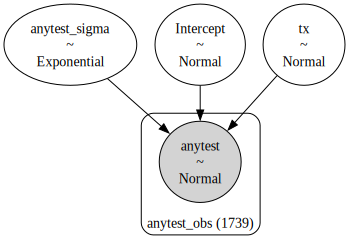

In [23]:
gaussian_model.build()
gaussian_model.graph()


In [37]:
gaussian_idata = gaussian_model.fit(
    draws=4_000, chains=5, nuts_sampler="numpyro", random_seed=rng
)


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:02.098796
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:03.790590
Transforming variables...
Transformation time =  0:00:00.026862


In [38]:
az.summary(data=gaussian_idata)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.211,0.016,0.182,0.243,0.0,0.0,20876.0,15434.0,1.0
tx,0.265,0.022,0.224,0.307,0.0,0.0,18746.0,14710.0,1.0
anytest_sigma,0.459,0.008,0.445,0.474,0.0,0.0,22501.0,15145.0,1.0


<module 'arviz' from '/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/arviz/__init__.py'>

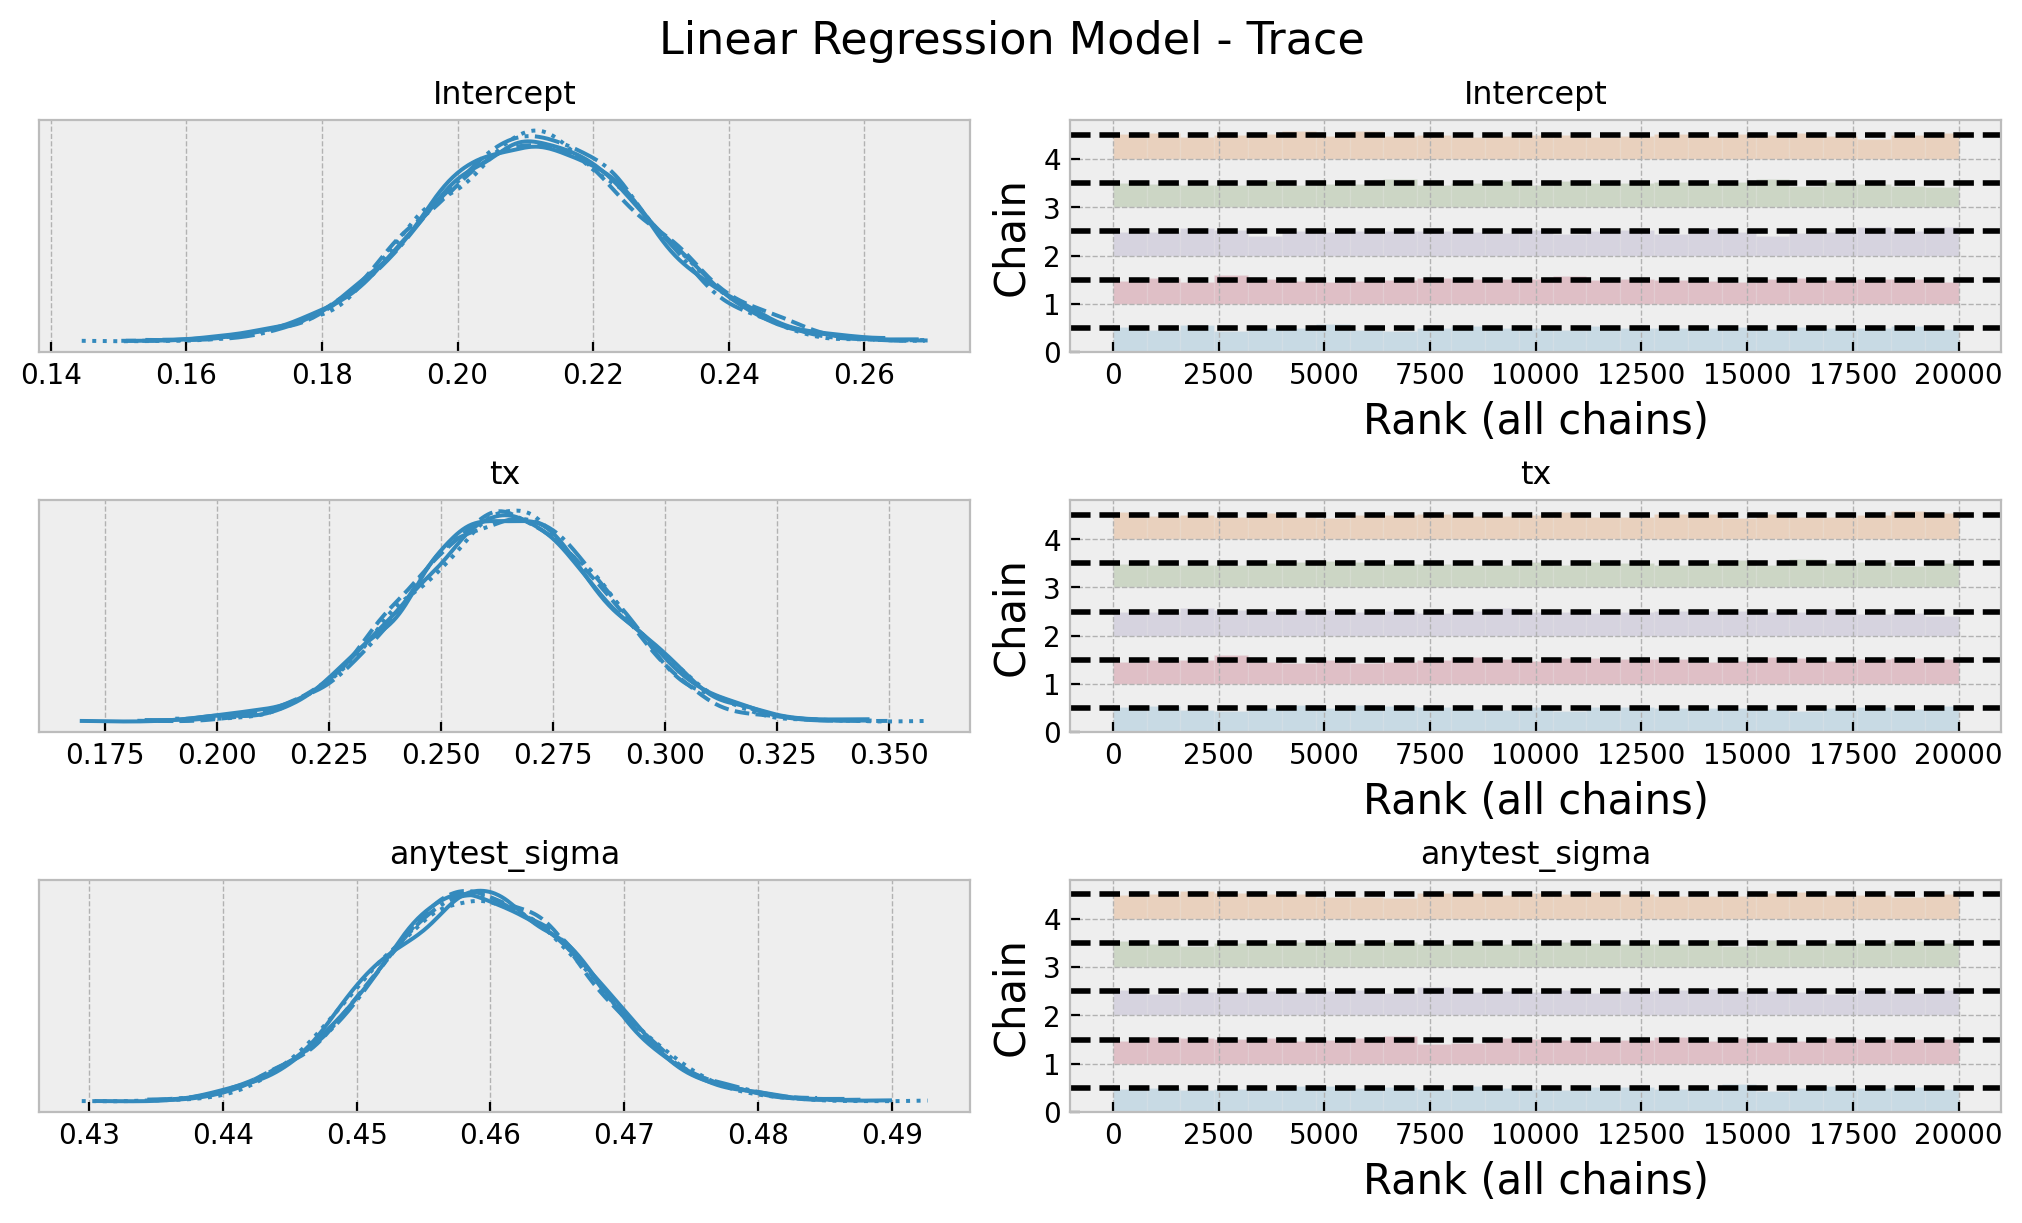

In [39]:
axes = az.plot_trace(
    data=gaussian_idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 6), "layout": "constrained"},
)
plt.gcf().suptitle("Linear Regression Model - Trace", fontsize=16);az

Text(0.5, 1.05, 'ATE Comparison')

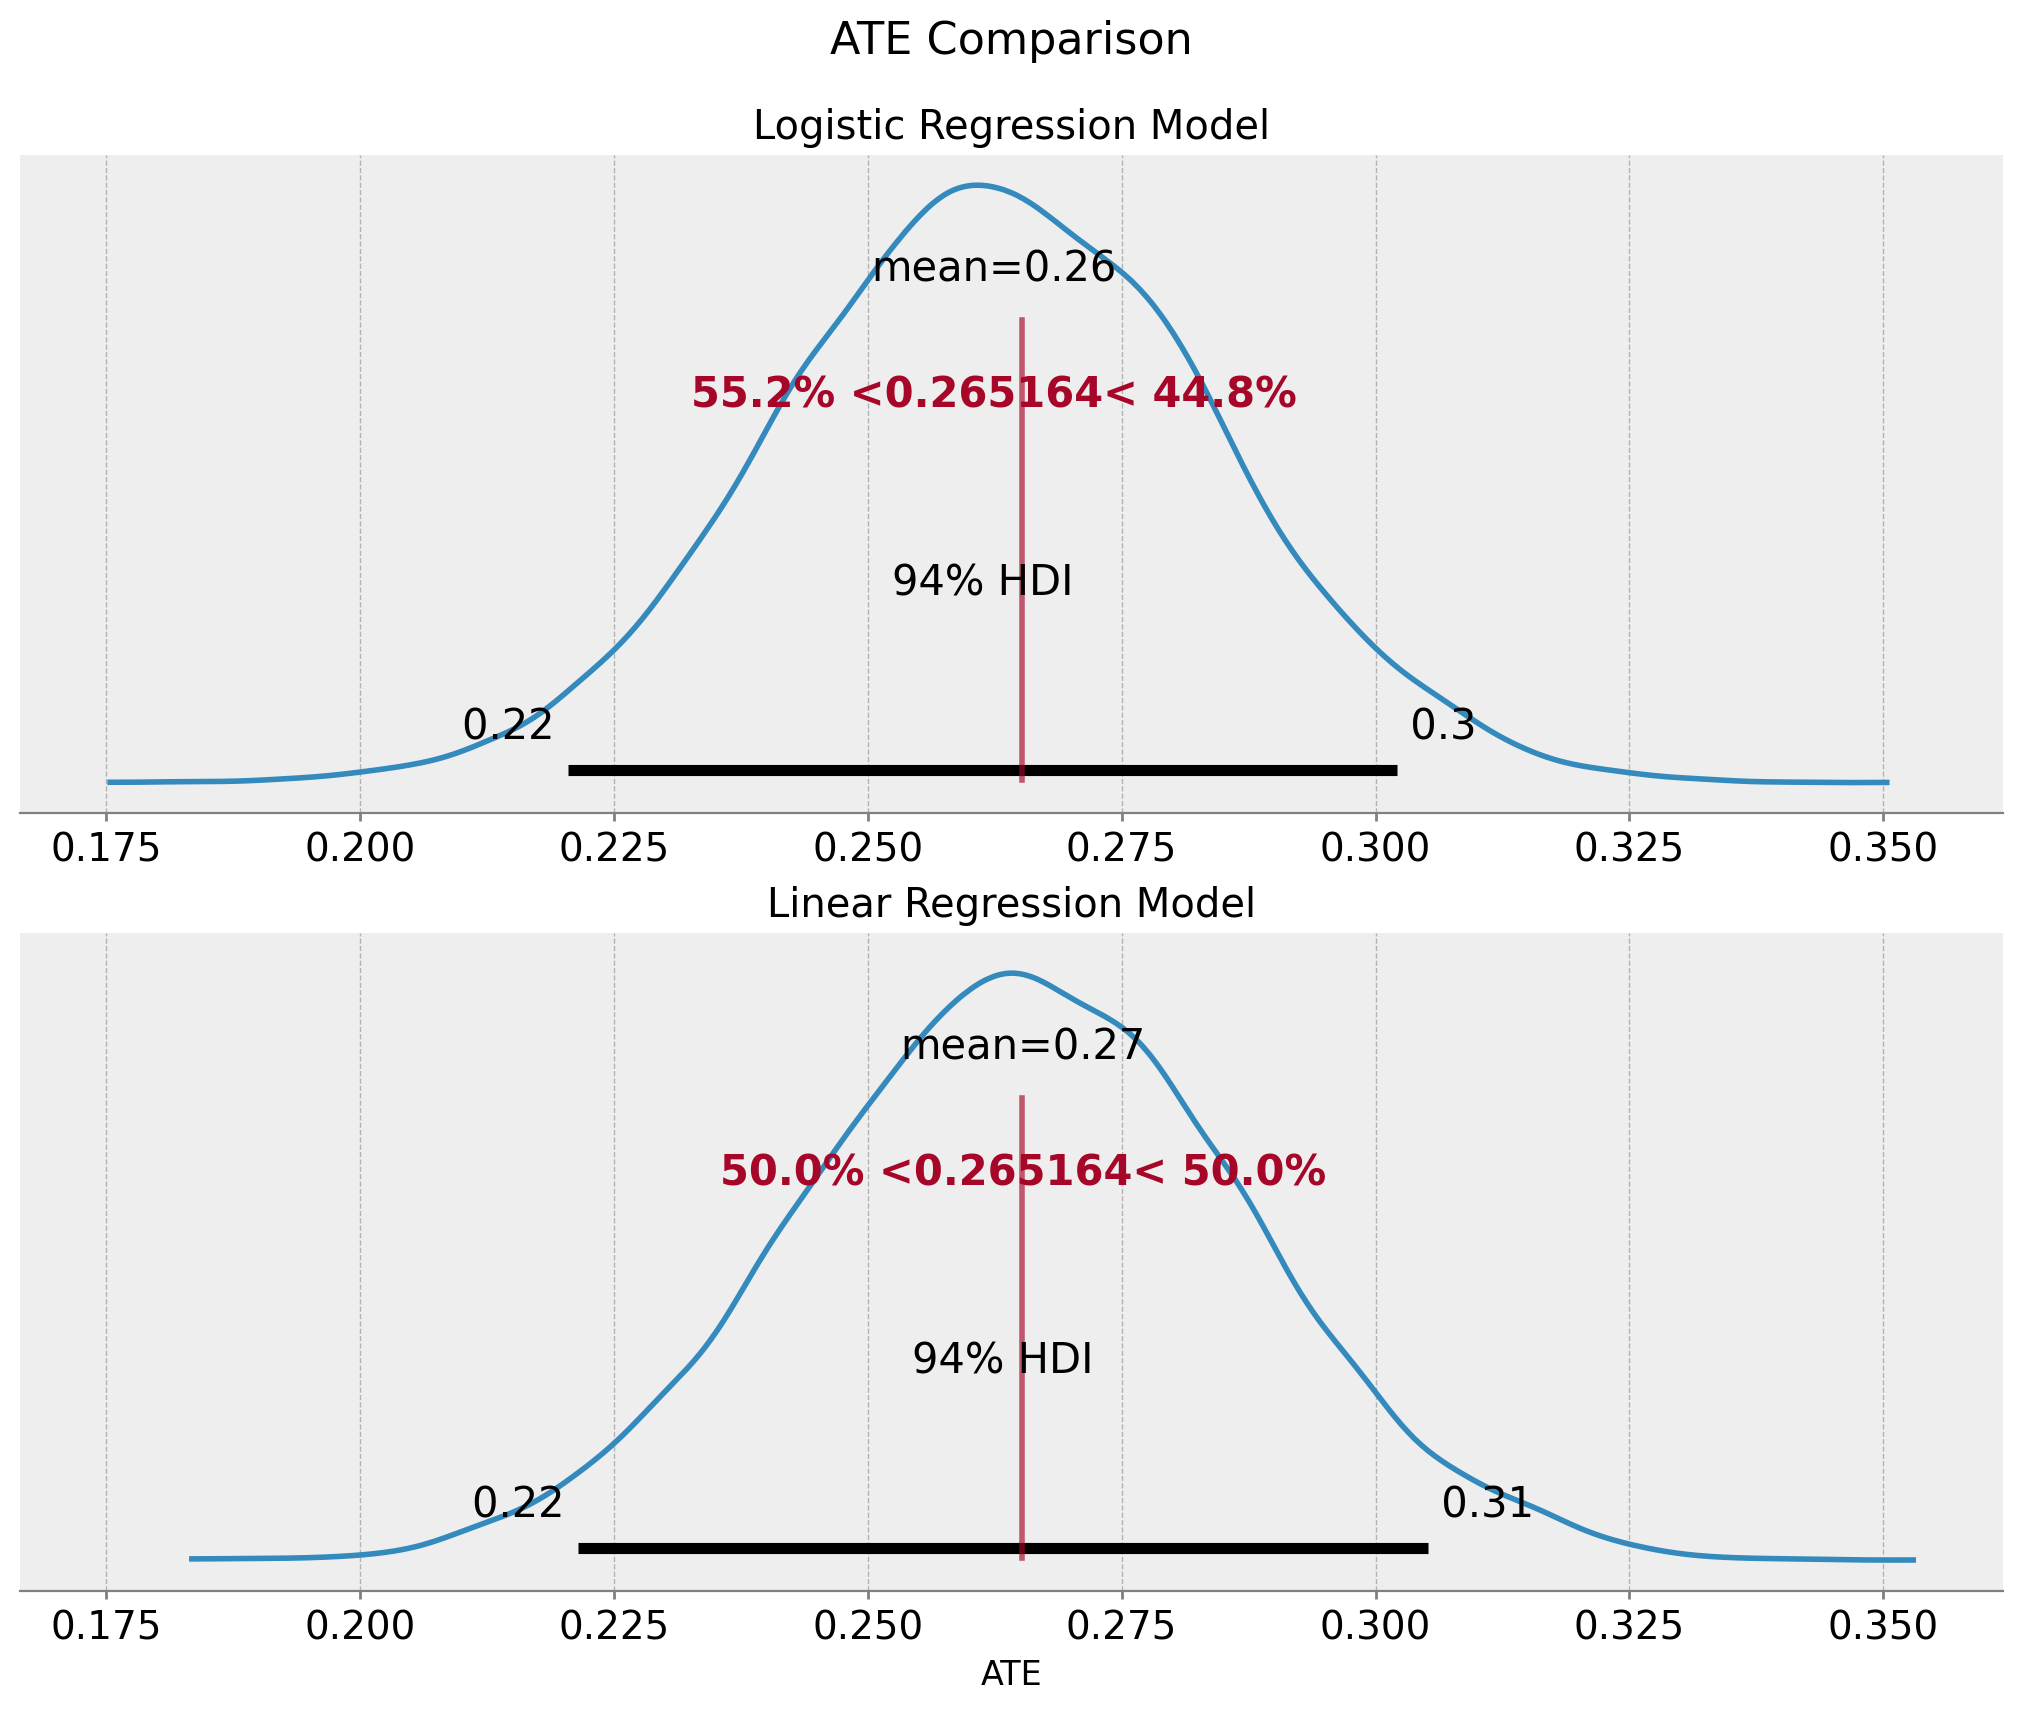

In [36]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10, 8), layout="constrained"
)
az.plot_posterior(data=ate_samples, ref_val=diff_means, ax=ax[0])
ax[0].set(title="Logistic Regression Model")
az.plot_posterior(data=gaussian_idata, var_names=["tx"], ref_val=diff_means, ax=ax[1], backend_kwargs={"alpha": 0.3})
ax[1].set(title="Linear Regression Model", xlabel="ATE")
fig.suptitle("ATE Comparison", y=1.05, fontsize=16)